In [1]:
%matplotlib inline
import pandas as pd
from pandas import set_option
#Limit dataframe exibition to 8 rows
set_option("display.max_rows", 5)
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gc

In [2]:
prev = pd.read_csv('./processed/prev.csv', encoding='latin1', sep=',')

In [3]:
prev.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
ignorado = pd.read_csv('./processed/arrec_ignorado.csv', encoding='latin1', sep=',')

In [5]:
ignorado.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
ignorado.drop('cd_ibge', axis=1, inplace=True)

Criação de um dataframe agrupado para análise por estados

In [7]:
agrupado = pd.DataFrame(prev.groupby(by=['estado','ano'])['vl_emissao','vl_arrecadado'].sum()).reset_index()

### Vamos começar olhando de forma macro como se comportam as curvas de arrecadação e emissão ao longo dos últimos anos

Primeiro vamos olhar as arrecadações que vem categoorizadas como ignoradas

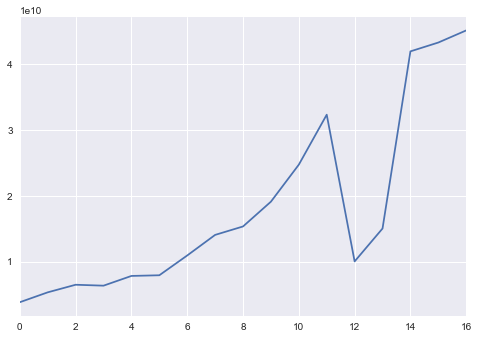

In [8]:
ignorado.ix[:,'vl_arrec'].plot(x=ignorado['ano'].unique())

Agora vamos olhar as curvas de emissão e arrecadação

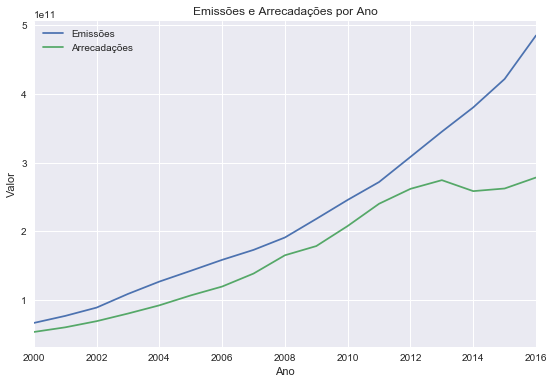

In [22]:
pd.DataFrame(agrupado.groupby(by=['ano'])['vl_emissao','vl_arrecadado'].sum()).plot(x=agrupado['ano'].unique(), \
                                                                                   figsize=[9,6])
plt.ylabel('Valor')
plt.xlabel('Ano')
plt.title('Emissões e Arrecadações por Ano')
plt.legend(['Emissões','Arrecadações'])

Chegou a hora de somar as arrecadações para analisar a diferença entre arrecadado e emitido de forma mais acertiva

In [24]:
por_ano = agrupado.groupby(by=['ano'])['vl_emissao','vl_arrecadado'].sum().reset_index()

In [25]:
por_ano

,ano,vl_emissao,vl_arrecadado
0,2000,66482356062,53326273372
1,2001,76729239461,60093616228
...,...,...,...
15,2015,421885626568,262329169837
16,2016,485265079339,278338187783


In [26]:
ignorado_por_ano = ignorado.drop('estado', axis=1)

In [27]:
por_ano_total = pd.merge(por_ano, ignorado_por_ano, how='inner', on='ano')

In [28]:
por_ano_total

,ano,vl_emissao,vl_arrecadado,vl_arrec
0,2000,66482356062,53326273372,3830461114
1,2001,76729239461,60093616228,5330180748
...,...,...,...,...
15,2015,421885626568,262329169837,43260504485
16,2016,485265079339,278338187783,45100620629


In [29]:
por_ano_total['vl_arrec_tot'] = por_ano_total['vl_arrecadado'] + por_ano_total['vl_arrec']

In [30]:
por_ano_total

,ano,vl_emissao,vl_arrecadado,vl_arrec,vl_arrec_tot
0,2000,66482356062,53326273372,3830461114,57156734486
1,2001,76729239461,60093616228,5330180748,65423796976
...,...,...,...,...,...
15,2015,421885626568,262329169837,43260504485,305589674322
16,2016,485265079339,278338187783,45100620629,323438808412


In [31]:
por_ano_total.drop(['vl_arrecadado', 'vl_arrec'], axis=1, inplace=True)

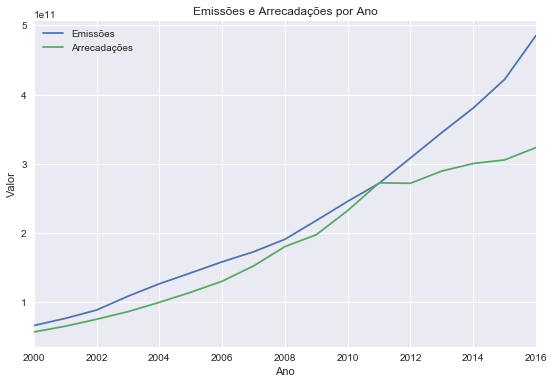

In [33]:
por_ano_total.ix[:, ['vl_emissao','vl_arrec_tot']].plot(x=agrupado['ano'].unique(), \
                                                                                   figsize=[9,6])
plt.ylabel('Valor')
plt.xlabel('Ano')
plt.title('Emissões e Arrecadações por Ano')
plt.legend(['Emissões','Arrecadações'])

###### Como vimos, de forma macro, realmente existe um déficit bem grande entre arrecadação e gastos na previdência. O déficit era pequeno até o ano de 2010. No ano de 2011 atingimos o "breake even point" e parecia que em 2012 teríamos um superávit, mas em 2012 a arrecadação antou de lado, com uma leve queda, enquanto as emissões continuaram a crescer. Nos anos seguintes as arrecadações voltaram a cresccer, mas de forma discreta enquanto as emissões cresceram de forma significativa, como mostra o aumento da angulação da curva

In [34]:
from sklearn import linear_model

In [35]:
por_ano_total

,ano,vl_emissao,vl_arrec_tot
0,2000,66482356062,57156734486
1,2001,76729239461,65423796976
...,...,...,...
15,2015,421885626568,305589674322
16,2016,485265079339,323438808412


In [36]:
regres = por_ano_total.ix[por_ano_total['ano'] <=2011, ['ano','vl_arrec_tot', 'vl_emissao']].reset_index(drop=True)

In [37]:
regres['dif'] = regres['vl_arrec_tot'] - regres['vl_emissao']

In [38]:
regres = regres.drop(['vl_arrec_tot', 'vl_emissao'], axis=1)

In [39]:
regres.to_csv('./processed/regres.csv', encoding='latin1')

In [40]:
y = regres['dif']

In [41]:
regres = regres.drop(['dif'], axis=1)

In [42]:
lin = linear_model.LinearRegression()
lin.fit(regres, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [43]:
dif = lin.predict(2012)
dif.astype(np.int64)

array([-14210886032], dtype=int64)

In [44]:
dif = lin.predict(2013)
dif.astype(np.int64)

array([-13795030806], dtype=int64)

In [45]:
dif = lin.predict(2047)
dif.astype(np.int64)

array([344046887], dtype=int64)

### Fazer uma regressão não é a melhor forma de prever um ponto pois estamos lidando com uma time series, então para essas predições usaremos o próximo notebook que tem código usando o Prophet do Facebook

### Vamos começar a investigar agora de forma mais micro

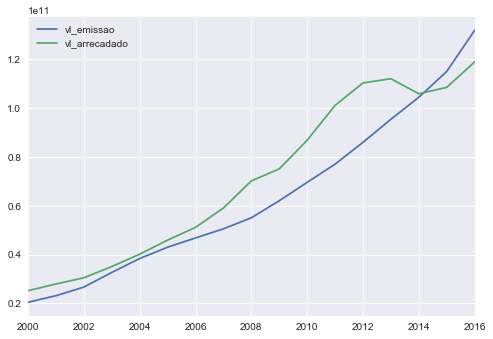

In [47]:
agrupado.ix[agrupado['estado']=='São Paulo', ['vl_emissao', 'vl_arrecadado']].plot(x=agrupado['ano'].unique())

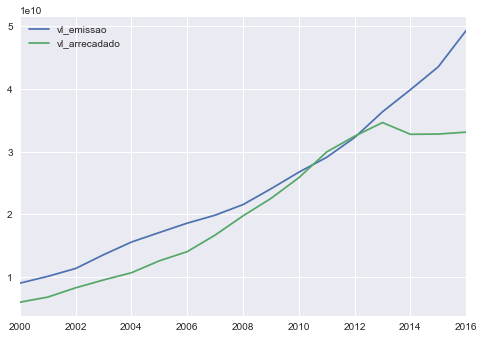

In [48]:
agrupado.ix[agrupado['estado']=='Rio de Janeiro', ['vl_emissao', 'vl_arrecadado']].plot(x=agrupado['ano'].unique())